In [1]:
# imports
import os
import sys


import pandas as pd
import numpy as np
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML


In [2]:
# Here we find our submodule directory, make sure it has notebooks, and add them to path and import

def findSubmoduleDir(path: str) -> str:
    path = os.path.abspath(path)
    if path == "/":
        # Could not find covidclinicaldata in current directory or in any parent directory
        # You can edit the CWPATH variable to point to the containing directory
        raise FileNotFoundError("Could not find the covidclinicaldata/ subdirectory")
    if os.path.isdir(path+'/covidclinicaldata'):
        return path+'/covidclinicaldata'
    return findSubmoduleDir('..')
    
def mustContainNotebooks(path: str):
    if not os.path.isdir(path+'/notebooks'):
        raise FileNotFoundError("Could not find Jupyter notebooks in covidclinicaldata/- is it initialized?")
        
#### DELETE THIS: don't supply system-specific paths to GitHub repos
CWPATH = '.'
DATA_SUFFIX = '.csv' # Assume any CSV is correct data
MOD_DIR = findSubmoduleDir(CWPATH)
mustContainNotebooks(MOD_DIR)
PROJ_DIR = os.path.abspath(MOD_DIR + '/..')
sys.path.insert(0, MOD_DIR+'/notebooks')

from ipynb.fs.full.data_processing import (
    filter_patients,
    filter_pos,
    get_sym_severity,
    get_sym_severity_score,
    is_abnormal_cxr,
    open_data, #This is being overridden
    plot_fill_rates,
    print_data_info,
    SYMPTOMS,
    VITALS,
)

In [3]:
# Read Data

## We'd like to use the original open_data function, but it takes no PATH argument.
## This one also ignores indexes
def open_data(path: str) -> pd.DataFrame:
    '''Open all data in `PATH`.
    Parameters
    ----------
    path : str
        The path to find data.

    
    Returns
    -------
    pandas.DataFrame
    '''    
    return pd.concat(
        [
            pd.read_csv(f'{path}/{filename}') 
            for filename in os.listdir(path) 
            if filename.endswith('.csv')
        ], ignore_index=True
    )

df = open_data(MOD_DIR + '/data')

In [4]:
## For analyzing and sanitizing- policies are detailed in comments
pd.set_option('display.max_columns', None)
def analyze_column(col: pd.Series) -> pd.Series:
    rows = [ "missing/empty", "Has NaNs", "dtype", "inferred type", "min,max", "n uniques"]
    values = [
        str(np.count_nonzero(col.isna())),
        str(col.hasnans),
        str(col.dtype),
        str(col.infer_objects().dtypes)
    ]
    
    if np.issubdtype(col.infer_objects().dtypes, np.number):
        values = values + [ 
            "(" + str(col.min()) + "," + str(col.max()) + ")",
            "N/A"
        ]
    else:
        values = values + [ 
            "N/A",
            str(col.nunique())
        ]
        # Add empty string to missing values
        if np.issubdtype(col.infer_objects().dtypes, np.object):
            values[0] = str(int(values[0]) + (col.values == '').sum())
    return pd.Series(values, name=col.name, index=rows)

def plot_analyze_column(col: pd.Series) -> pd.Series:
    plt.rcParams.update({'figure.max_open_warning': 0})
    if np.issubdtype(col.infer_objects().dtypes, np.number):
        fig = plt.figure(figsize=(5,5), dpi=80)
        ax = sns.distplot(col, kde=False, rug=True)
    elif np.issubdtype(col.infer_objects().dtypes, np.object):
            fig = plt.figure(figsize=(5,5), dpi=80)
            counts = Counter(col)
            counts_df = pd.DataFrame.from_dict(counts, orient='index')
            _ = counts_df.plot(kind='bar', title=col.name, legend=False)
    return None

In [5]:
# Let's drop some columns we know we're not interested in.
# We're using cxr_label instead of the impressions/findings regex in data_processing.ipynb
df = df.drop([
'test_name',
'swab_type',
'cxr_link',
'cxr_findings',
'cxr_impression'
], axis='columns', errors='ignore')

In [6]:
df.apply(analyze_column, axis='index', result_type="reduce")

,batch_date,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,copd,autoimmune_dis,smoker,temperature,pulse,sys,dia,rr,sats,rapid_flu_results,rapid_strep_results,ctab,labored_respiration,rhonchi,wheezes,days_since_symptom_onset,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat,cxr_label,er_referral
missing/empty,0,0,0,169,1501,0,0,0,0,0,0,0,0,4627,4644,4618,4618,5407,4783,11004,11083,5293,4146,6658,6344,7596,15,9507,2532,206,10220,187,176,183,190,190,187,182,183,10716,0
Has NaNs,False,False,False,True,True,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
dtype,object,object,int64,object,object,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,bool
inferred type,object,object,int64,object,object,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,bool
"min,max",N/A,N/A,"(-3,90)",N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,"(34.95,39.4)","(40.0,150.0)","(75.0,235.0)","(36.0,135.0)","(10.0,32.0)","(76.0,100.0)",N/A,N/A,N/A,N/A,N/A,N/A,"(1.0,300.0)",N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
n uniques,11,2,N/A,2,2,2,2,2,2,2,2,2,2,N/A,N/A,N/A,N/A,N/A,N/A,2,2,2,2,2,2,N/A,2,3,2,2,3,2,2,2,2,2,2,2,2,3,1


<Figure size 400x400 with 0 Axes>

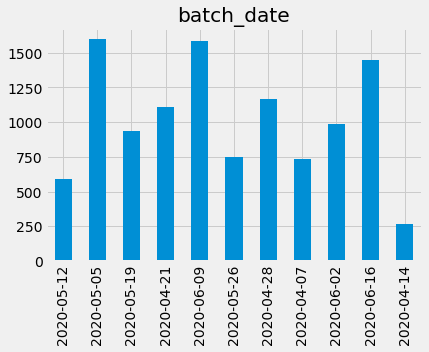

<Figure size 400x400 with 0 Axes>

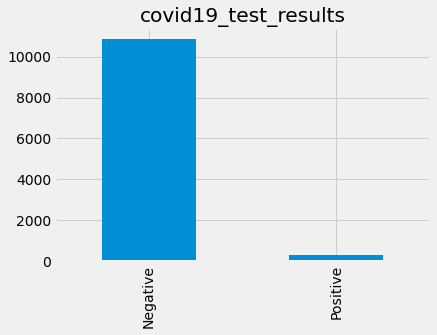

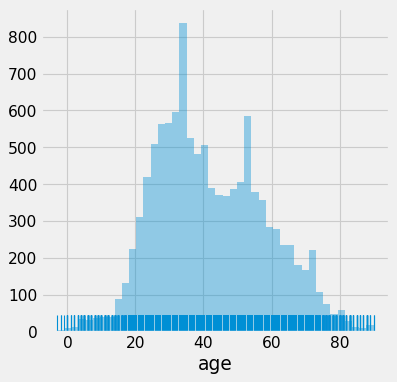

<Figure size 400x400 with 0 Axes>

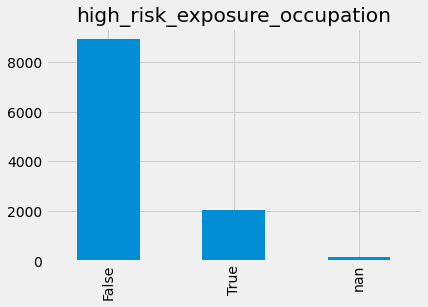

<Figure size 400x400 with 0 Axes>

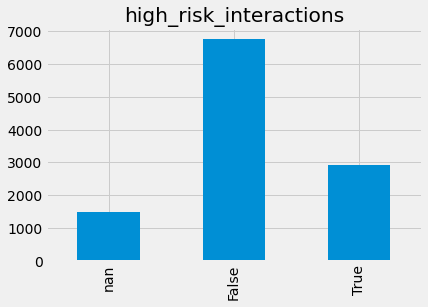

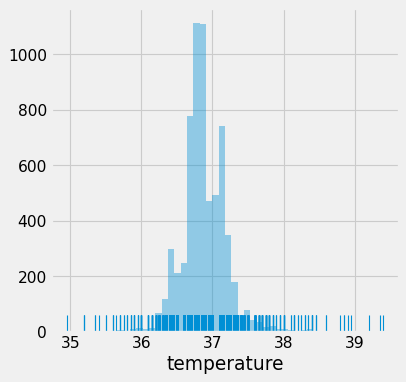

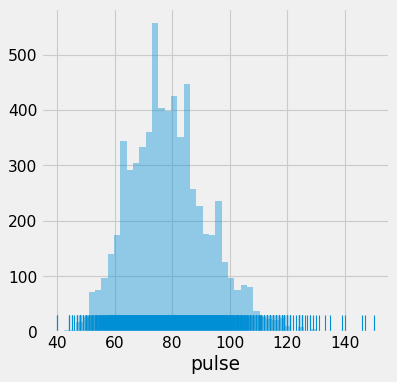

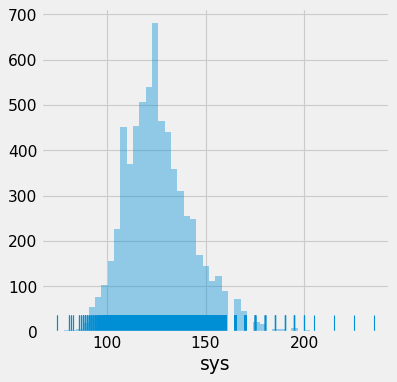

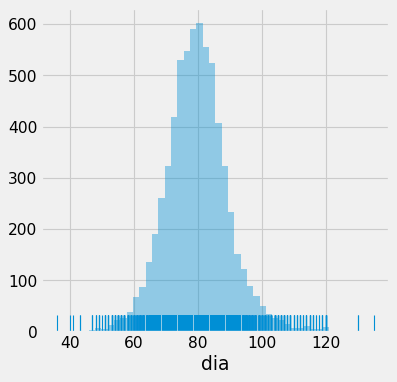

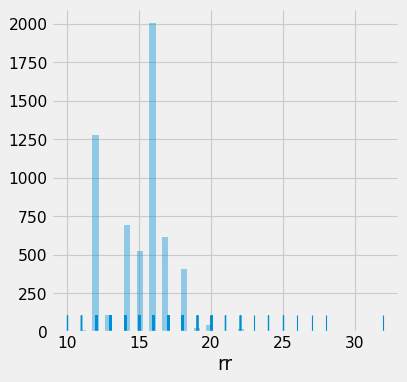

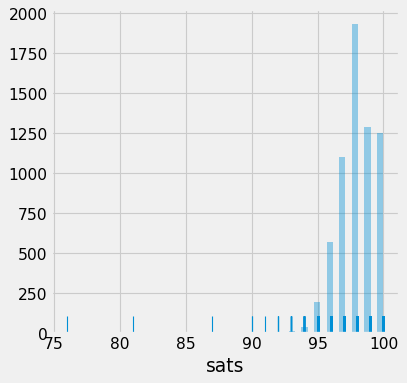

<Figure size 400x400 with 0 Axes>

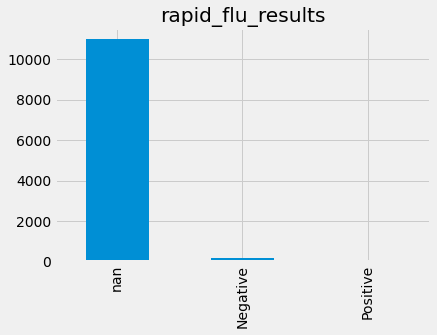

<Figure size 400x400 with 0 Axes>

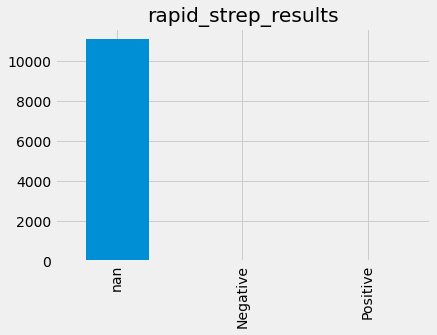

<Figure size 400x400 with 0 Axes>

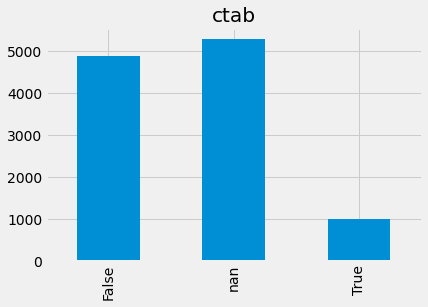

<Figure size 400x400 with 0 Axes>

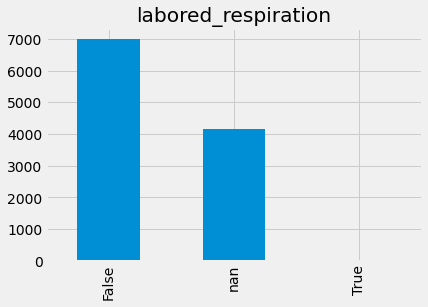

<Figure size 400x400 with 0 Axes>

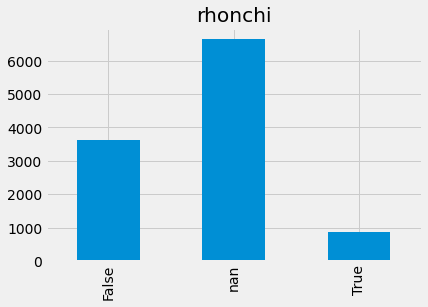

<Figure size 400x400 with 0 Axes>

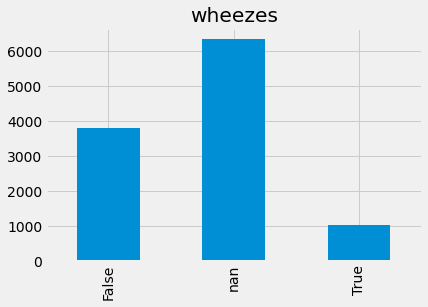

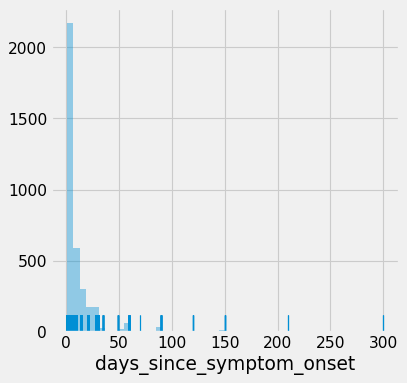

<Figure size 400x400 with 0 Axes>

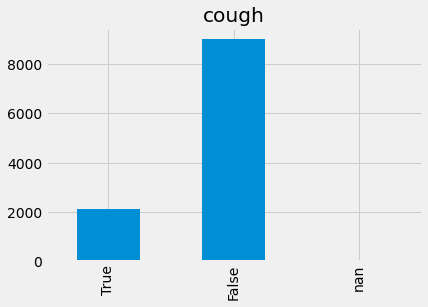

<Figure size 400x400 with 0 Axes>

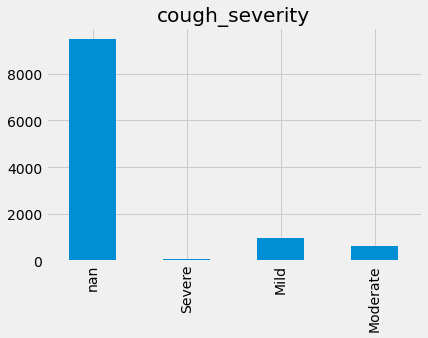

<Figure size 400x400 with 0 Axes>

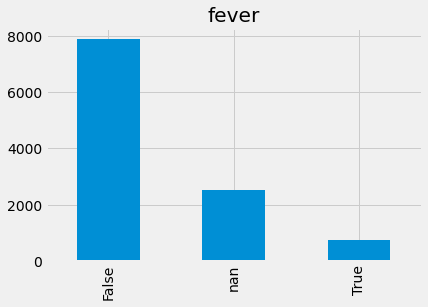

<Figure size 400x400 with 0 Axes>

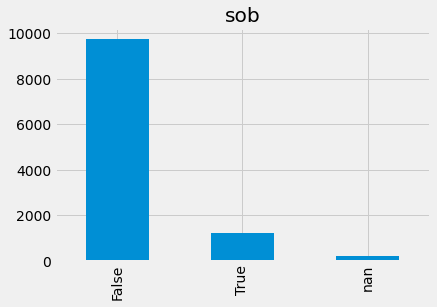

<Figure size 400x400 with 0 Axes>

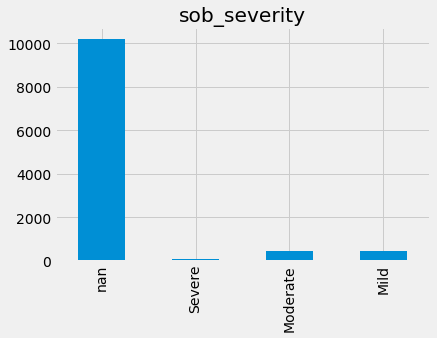

<Figure size 400x400 with 0 Axes>

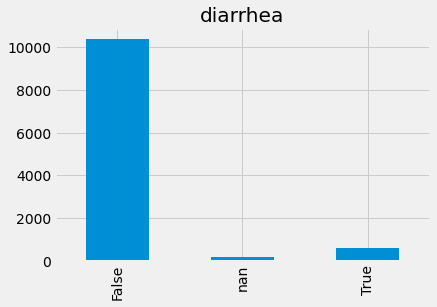

<Figure size 400x400 with 0 Axes>

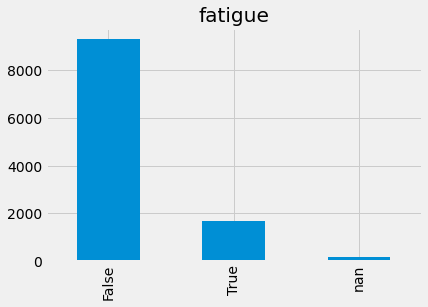

<Figure size 400x400 with 0 Axes>

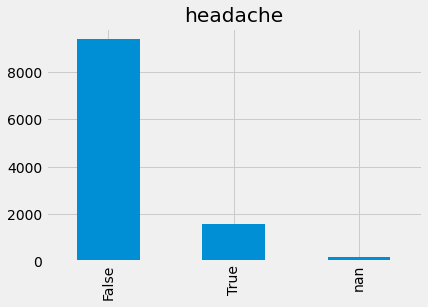

<Figure size 400x400 with 0 Axes>

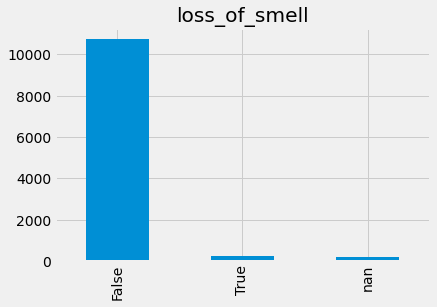

<Figure size 400x400 with 0 Axes>

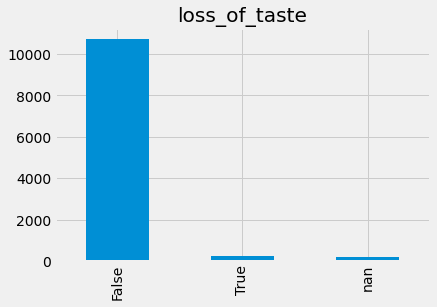

<Figure size 400x400 with 0 Axes>

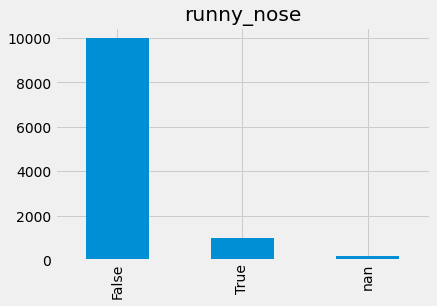

<Figure size 400x400 with 0 Axes>

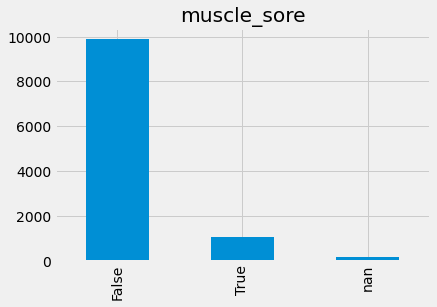

<Figure size 400x400 with 0 Axes>

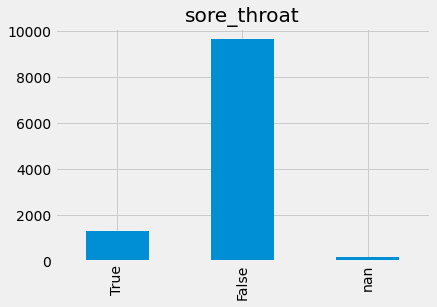

<Figure size 400x400 with 0 Axes>

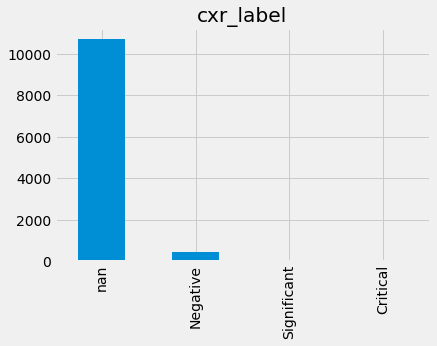

In [7]:
_ = df.apply(plot_analyze_column, axis='index')

## Here's how we'll 'fix' the data:

We've already dropped some columns. We'll state policies here for 

* adding in missing values
* converting as much as possible to numbers (everything will be normalized 0-1
* bounding data to be sane
* simplifying

### batch_date
Convert this to a date, where 0 is the earliest and 1 is the latest.
### covid19_test_results
This should be positive (1) or negative (0)
### age
This should be abouve 0, and should be present.
If no age data, throw the data point out entirely.
### high_risk_exposure_occupation
This should be assumed False (and may be combined with high_risk_interactions)
### high_risk_interactions
This should be assumed False (and may be combined with high_risk_exposure_occupation)
### diabetes
Assumed false
### chd
Assumed false
### htn
Assumed false
### cancer
Assumed false
### asthma
Assumed false
### copd
Assumed false
### autoimmune_dis
Assumed false
### smoker
Assumed false
## Signs/Vitals
If no signs or vitals are present, we can assume that the clinicians assessed by patient presentation that the vitals were relatively normal, and we will fill in values as such. The other solution would be to present outliar values, and all non-present vitals would become their own cluster. We need to be reasonable in what values we accept, but that is **TODO**.
### temperature
### pulse
### sys
### dia
### rr
### sats
### rapid_flu_results
Rapid flu results should be assumed negative (clinician saw no reason to order), and can be combined with rapid_strep_results to form "counter_indication".
### rapid_strep_results
Rapid strep results should be assumed negative (clinician saw now reason to order), and can be combined with rapid_flu_results to form "counter_indication" category.
### ctab
Ctab should probably be droped since it's already described by the following three categories:
### labored
Assumed false.
### rhonchi
Assumed false.
### wheezes
Assumed false.
### days_since
This needs to be checked for reasonable bounds. It can be normalized easily.
## Symptoms
One solution is to combine all symptoms into a severity score, as done by data_processing.ipynb.
### cough
Cough and cough_severity are really part of the same data.
### cough_severity
Cough and cough_severity are really part of the same data.
### fever
Fever may be the same as temperature unless it has passed?
### sob
Sob and sob_severity are really part of the same data.
### sob_severity
Sob and sob_severity are really part of the same data.
### diarrhea
Diarrhea is binary.
### fatigue
Fatigue is binary.
### headache
Headache is binary.
### loss_of_smell
Loss_of_smell is binary.
### loss_of_taste
Loss_of_taste is binary.
### runny_nose
Runny_nose is binary.
### muscle_sore
Muscle_sore is binary.
### sore_throat
Soure_throat is binary.
### cxr_label
Cxr_labels should map to a severity number but shoudl assumed to be None.
### er_referral
This has been always false.

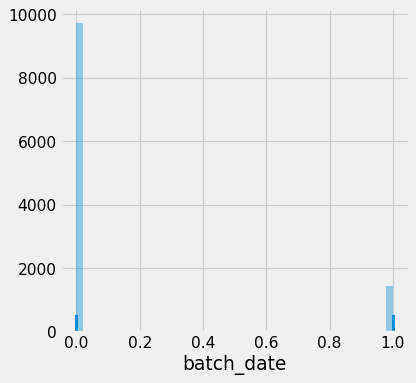

In [13]:
pd.set_option('display.max_columns', None)
# use df.head(N) to test on N first entries
df = df.head(100).apply(func=normalize, axis='index')

In [12]:
# This does nothing, it's left here as scratch
def ajs_normalize(df: pd.Series) -> pd.Series:
    if df[ 'covid19_test_results' ] == "Positive":
        return pd.Series('Yerp')
    elif df[ 'covid19_test_results' ] == "Negative":
        return pd.Series('Nerp')
    else:
        return pd.Series('wut')
#norm_data = data.apply(ajs_normalize, axis=1)